[R-CNN](https://github.com/rbgirshick/rcnn) is a state-of-the-art detector that classifies region proposals by a finetuned Caffe model. For the full details of the R-CNN system and model, refer to its project site and the paper:

> *Rich feature hierarchies for accurate object detection and semantic segmentation*. Ross Girshick, Jeff Donahue, Trevor Darrell, Jitendra Malik. CVPR 2014. [Arxiv 2013](http://arxiv.org/abs/1311.2524).

In this example, we do detection by a pure Caffe edition of the R-CNN model for ImageNet. The R-CNN detector outputs class scores for the 200 detection classes of ILSVRC13. Keep in mind that these are raw one vs. all SVM scores, so they are not probabilistically calibrated or exactly comparable across classes. Note that this off-the-shelf model is simply for convenience, and is not the full R-CNN model.

Let's run detection on an image of a bicyclist riding a fish bike in the desert (from the ImageNet challenge—no joke).

First, we'll need region proposals and the Caffe R-CNN ImageNet model:

- [Selective Search](http://koen.me/research/selectivesearch/) is the region proposer used by R-CNN. The [selective_search_ijcv_with_python](https://github.com/sergeyk/selective_search_ijcv_with_python) Python module takes care of extracting proposals through the selective search MATLAB implementation. To install it, download the module and name its directory `selective_search_ijcv_with_python`, run the demo in MATLAB to compile the necessary functions, then add it to your `PYTHONPATH` for importing. (If you have your own region proposals prepared, or would rather not bother with this step, [detect.py](https://github.com/BVLC/caffe/blob/master/python/detect.py) accepts a list of images and bounding boxes as CSV.)

-Run `./scripts/download_model_binary.py models/bvlc_reference_rcnn_ilsvrc13` to get the Caffe R-CNN ImageNet model.

With that done, we'll call the bundled `detect.py` to generate the region proposals and run the network. For an explanation of the arguments, do `./detect.py --help`.

In [74]:
!mkdir -p _temp
!echo `pwd`/images/fish-bike.jpg > _temp/det_input.txt
!../python/detect.py --crop_mode=selective_search --pretrained_model=../models/bvlc_reference_rcnn_ilsvrc13/bvlc_reference_rcnn_ilsvrc13.caffemodel --model_def=../models/bvlc_reference_rcnn_ilsvrc13/deploy.prototxt --gpu --raw_scale=255 _temp/det_input.txt _temp/det_output.h5

GPU mode
W1018 20:04:43.592116  8575 _caffe.cpp:139] DEPRECATION WARNING - deprecated use of Python interface
W1018 20:04:43.592146  8575 _caffe.cpp:140] Use this instead (with the named "weights" parameter):
W1018 20:04:43.592161  8575 _caffe.cpp:142] Net('../models/bvlc_reference_rcnn_ilsvrc13/deploy.prototxt', 1, weights='../models/bvlc_reference_rcnn_ilsvrc13/bvlc_reference_rcnn_ilsvrc13.caffemodel')
I1018 20:04:43.593565  8575 net.cpp:51] Initializing net from parameters: 
name: "R-CNN-ilsvrc13"
state {
  phase: TEST
  level: 0
}
layer {
  name: "data"
  type: "Input"
  top: "data"
  input_param {
    shape {
      dim: 10
      dim: 3
      dim: 227
      dim: 227
    }
  }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  convolution_param {
    num_output: 96
    kernel_size: 11
    stride: 4
  }
}
layer {
  name: "relu1"
  type: "ReLU"
  bottom: "conv1"
  top: "conv1"
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
 

This run was in GPU mode. For CPU mode detection, call `detect.py` without the `--gpu` argument.

Running this outputs a DataFrame with the filenames, selected windows, and their detection scores to an HDF5 file.
(We only ran on one image, so the filenames will all be the same.)

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

print '\n', pd.__version__, '\n'

df = pd.read_hdf('_temp/det_output.h5', 'df')
print(df.shape)
print(df.iloc[0])


0.20.3 

(1570, 5)
prediction    [-2.66284, -2.79619, -2.82898, -3.15738, -1.89...
ymin                                                     79.846
xmin                                                       9.62
ymax                                                     246.31
xmax                                                    339.624
Name: /home/huht/caffe/examples/images/fish-bike.jpg, dtype: object


1570 regions were proposed with the R-CNN configuration of selective search. The number of proposals will vary from image to image based on its contents and size -- selective search isn't scale invariant.

In general, `detect.py` is most efficient when running on a lot of images: it first extracts window proposals for all of them, batches the windows for efficient GPU processing, and then outputs the results.
Simply list an image per line in the `images_file`, and it will process all of them.

Although this guide gives an example of R-CNN ImageNet detection, `detect.py` is clever enough to adapt to different Caffe models’ input dimensions, batch size, and output categories. You can switch the model definition and pretrained model as desired. Refer to `python detect.py --help` for the parameters to describe your data set. There's no need for hardcoding.

Anyway, let's now load the ILSVRC13 detection class names and make a DataFrame of the predictions. Note you'll need the auxiliary ilsvrc2012 data fetched by `data/ilsvrc12/get_ilsvrc12_aux.sh`.

In [78]:
with open('../data/ilsvrc12/det_synset_words.txt') as f:
    labels_df = pd.DataFrame([
        {
            'synset_id': l.strip().split(' ')[0],
            'name': ' '.join(l.strip().split(' ')[1:]).split(',')[0]
        }
        for l in f.readlines()
    ])

print labels_df.head(10)

predictions_df = pd.DataFrame(np.vstack(df.prediction.values), columns=labels_df['name'])
print '\n'
print(predictions_df.iloc[0])

        name  synset_id
0  accordion  n02672831
1   airplane  n02691156
2        ant  n02219486
3   antelope  n02419796
4      apple  n07739125
5  armadillo  n02454379
6  artichoke  n07718747
7        axe  n02764044
8   baby bed  n02766320
9   backpack  n02769748


name
accordion         -2.662839
airplane          -2.796189
ant               -2.828984
antelope          -3.157378
apple             -1.894942
armadillo         -2.447418
artichoke         -2.208344
axe               -2.429343
baby bed          -2.870967
backpack          -2.212001
bagel             -2.695294
balance beam      -2.722746
banana            -2.461525
band aid          -1.688009
banjo             -2.324180
baseball          -2.281750
basketball        -2.689468
bathing cap       -2.874586
beaker            -2.402559
bear              -3.270154
bee               -3.024797
bell pepper       -2.483999
bench             -1.859547
bicycle           -2.921004
binder            -2.472090
bird              -3.677524
b

Let's look at the activations.

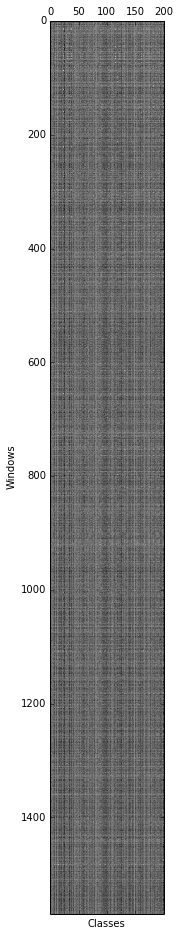

In [80]:
plt.gray()
plt.matshow(predictions_df.values)
plt.xlabel('Classes')
plt.ylabel('Windows')

Now let's take max across all windows and plot the top classes.

In [83]:
max_s = predictions_df.max(0)  
max_s = max_s.sort_values(ascending=False)
#max_s.sort(ascending=False)
print(max_s[:10])

name
person          1.993261
bicycle         0.789001
unicycle        0.057734
motorcycle      0.003603
banjo          -0.001440
electric fan   -0.220595
cart           -0.225192
turtle         -0.232450
lizard         -0.354708
helmet         -0.477555
dtype: float32


The top detections are in fact a person and bicycle.
Picking good localizations is a work in progress; we pick the top-scoring person and bicycle detections.

Top detection:
name
person             1.993261
turtle            -1.036920
swimming trunks   -1.172014
plastic bag       -1.196152
seal              -1.208147
dtype: float32

Second-best detection:
name
bicycle        0.789001
unicycle      -0.352723
scorpion      -0.900089
lobster       -1.011195
soccer ball   -1.074003
dtype: float32


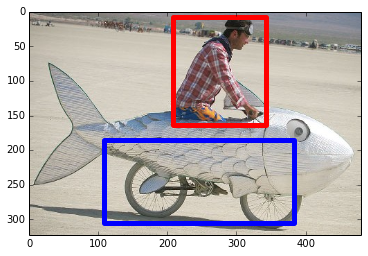

In [85]:
# Find, print, and display the top detections: person and bicycle.
i = predictions_df['person'].argmax()
j = predictions_df['bicycle'].argmax()

# Show top predictions for top detection.
f = pd.Series(df['prediction'].iloc[i], index=labels_df['name'])

print('Top detection:')
#print(f.order(ascending=False)[:5])
print f.sort_values(ascending=False)[:5]
print('')

# Show top predictions for second-best detection.
f = pd.Series(df['prediction'].iloc[j], index=labels_df['name'])
print('Second-best detection:')
#print(f.order(ascending=False)[:5])
print f.sort_values(ascending=False)[:5]

# Show top detection in red, second-best top detection in blue.
im = plt.imread('images/fish-bike.jpg')
plt.imshow(im)
currentAxis = plt.gca()

det = df.iloc[i]
coords = (det['xmin'], det['ymin']), det['xmax'] - det['xmin'], det['ymax'] - det['ymin']
currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor='r', linewidth=5))

det = df.iloc[j]
coords = (det['xmin'], det['ymin']), det['xmax'] - det['xmin'], det['ymax'] - det['ymin']
currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor='b', linewidth=5))

That's cool. Let's take all 'bicycle' detections and NMS them to get rid of overlapping windows.

In [86]:
def nms_detections(dets, overlap=0.3):
    """
    Non-maximum suppression: Greedily select high-scoring detections and
    skip detections that are significantly covered by a previously
    selected detection.

    This version is translated from Matlab code by Tomasz Malisiewicz,
    who sped up Pedro Felzenszwalb's code.

    Parameters
    ----------
    dets: ndarray
        each row is ['xmin', 'ymin', 'xmax', 'ymax', 'score']
    overlap: float
        minimum overlap ratio (0.3 default)

    Output
    ------
    dets: ndarray
        remaining after suppression.
    """
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    ind = np.argsort(dets[:, 4])

    w = x2 - x1
    h = y2 - y1
    area = (w * h).astype(float)

    pick = []
    while len(ind) > 0:
        i = ind[-1]
        pick.append(i)
        ind = ind[:-1]

        xx1 = np.maximum(x1[i], x1[ind])
        yy1 = np.maximum(y1[i], y1[ind])
        xx2 = np.minimum(x2[i], x2[ind])
        yy2 = np.minimum(y2[i], y2[ind])

        w = np.maximum(0., xx2 - xx1)
        h = np.maximum(0., yy2 - yy1)

        wh = w * h
        o = wh / (area[i] + area[ind] - wh)

        ind = ind[np.nonzero(o <= overlap)[0]]

    return dets[pick, :]

In [87]:
scores = predictions_df['bicycle']
windows = df[['xmin', 'ymin', 'xmax', 'ymax']].values
dets = np.hstack((windows, scores[:, np.newaxis]))
nms_dets = nms_detections(dets)

Show top 3 NMS'd detections for 'bicycle' in the image and note the gap between the top scoring box (red) and the remaining boxes.

scores: [ 0.78900111 -0.73389643 -1.40267658]


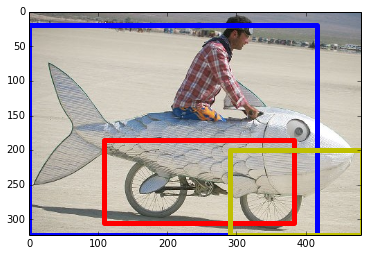

In [88]:
plt.imshow(im)
currentAxis = plt.gca()
colors = ['r', 'b', 'y']
for c, det in zip(colors, nms_dets[:3]):
    currentAxis.add_patch(
        plt.Rectangle((det[0], det[1]), det[2]-det[0], det[3]-det[1],
        fill=False, edgecolor=c, linewidth=5)
    )
print 'scores:', nms_dets[:3, 4]

This was an easy instance for bicycle as it was in the class's training set. However, the person result is a true detection since this was not in the set for that class.

You should try out detection on an image of your own next!

(Remove the temp directory to clean up, and we're done.)

In [59]:
!rm -rf _temp